In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Transform video into numpy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

##### getOpticalFlow: use to calculate the optical flow between each pair of frames
Input: video<br>
Output:

flows_x: Optical flow along the x-axis for each framepair

flows_y: Optical flow along the y-axis for each frame pair,

In [ ]:
def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel].dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img,(224,224,1)))

    flows = []
    for i in range(0,len(video)-1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i+1], None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224,224,2)))

    return np.array(flows, dtype=np.float32)

##### Video2Npy
Input: Video path and resize vaule(224 x 224) default

Output: The array [frames, 224, 244, 5] (R G B x-axist y-axist)



In [ ]:
def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result

In [ ]:
def Save2Npy(file_dir, save_dir):
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

#### TODO Here

In [ ]:
source_path = '/content/drive/MyDrive/big data/train vid'
target_path = '/content/drive/MyDrive/big data/source'

for f1 in ['train', 'val']:
    for f2 in ['Normal', 'Restrict']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


# Build and load model

### Data loader

In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=2f25af0159da1d63efff204b3ebcace633adcd022a659a77c329a4195fed1b4f
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
from keras.utils import Sequence
from keras.utils import to_categorical

class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args:
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        # Initialize the params
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data()
        # Print basic statistics information
        self.print_stats()
        return None

    def search_data(self):
        X_path = []
        Y_dict = {}
        # list all kinds of sub-folders
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                # append the each file path, and keep its label
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict

    def print_stats(self):
        # calculate basic information
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None

    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        # load data into memory, you can change the np.load to any method you want
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y

    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video)
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i])
                except:
                    padding.append(video[0])
            sampled_video += padding
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    def random_clip(self, video, target_frames=64):
        start_point = np.random.randint(len(video)-target_frames)
        return video[start_point:start_point+target_frames]

    def dynamic_crop(self, video):
        # extract layer of optical flow from video
        opt_flows = video[...,3]
        # sum of optical flow magnitude of individual frame
        magnitude = np.sum(opt_flows, axis=0)
        # filter slight noise by threshold
        thresh = np.mean(magnitude)
        magnitude[magnitude<thresh] = 0
        # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
        x_pdf = np.sum(magnitude, axis=1) + 0.001
        y_pdf = np.sum(magnitude, axis=0) + 0.001
        # normalize PDF of x and y so that the sum of probs = 1
        x_pdf /= np.sum(x_pdf)
        y_pdf /= np.sum(y_pdf)
        # randomly choose some candidates for x and y
        x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
        y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
        # get the mean of x and y coordinates for better robustness
        x = int(np.mean(x_points))
        y = int(np.mean(y_points))
        # avoid to beyond boundaries of array
        x = max(56,min(x,167))
        y = max(56,min(y,167))
        # get cropped video
        return video[:,x-56:x+56,y-56:y+56,:]

    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video

    def load_data(self, path):
        # load the processed .npy files which have 5 channels (1-3 for RGB, 4-5 for optical flows)
        data = np.load(path, mmap_mode='r')
        data = np.float32(data)
        # sampling 64 frames uniformly from the entire video
        data = self.uniform_sampling(video=data, target_frames=64)
        # whether to utilize the data augmentation
        if  self.data_aug:
            data[...,:3] = self.color_jitter(data[...,:3])
            data = self.random_flip(data, prob=0.5)
        # normalize rgb images and optical flows, respectively
        data[...,:3] = self.normalize(data[...,:3])
        data[...,3:] = self.normalize(data[...,3:])
        return data

## Build model

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add, Multiply, Lambda

In [ ]:
# extract the rgb images
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

# extract the optical flows
def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt

In [ ]:
inputs = Input(shape=(64,224,224,5))

rgb = Lambda(get_rgb,output_shape=None)(inputs)
opt = Lambda(get_opt,output_shape=None)(inputs)

##################################################### RGB channel
rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

##################################################### Optical Flow channel
opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)


##################################################### Fusion and Pooling
x = Multiply()([rgb,opt])
x = MaxPooling3D(pool_size=(8,1,1))(x)

##################################################### Merging Block
x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,3,3))(x)

##################################################### FC Layers
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Build the model
pred = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 224, 224, 5)]    0         []                            
                                                                                                  
 lambda (Lambda)             (None, 64, 224, 224, 3)      0         ['input_1[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 64, 224, 224, 2)      0         ['input_1[0][0]']             
                                                                                                  
 conv3d (Conv3D)             (None, 64, 224, 224, 16)     448       ['lambda[0][0]']              
                                                                                              

### Set gru

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# from keras.utils import multi_gpu_model
# parallel_model = multi_gpu_model(model, gpus=4)

In [ ]:
from keras.optimizers import Adam, SGD

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Learning Rate Scheduler
import keras.backend as K
from keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.7)
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

In [ ]:
# Saving the best model and training logs
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras

class MyCbk(keras.callbacks.Callback):

    def __init__(self, model):
         self.model_to_save = model

    def on_epoch_end(self, epoch, logs=None):
        self.model_to_save.save('/content/drive/MyDrive/big data/model/model_at_epoch_%d.h5' % (epoch+1))

check_point = MyCbk(model)


filename = 'Logs/ours_log.csv'
csv_logger = CSVLogger(filename, separator=',', append=True)

In [ ]:
callbacks_list = [check_point, csv_logger, reduce_lr]

In [ ]:
# set essential params
num_epochs  = 5
num_workers = 16
batch_size  = 8

In [ ]:
# init data generator

dataset = 'ViolentFlow-opt'

train_generator = DataGenerator(directory='/content/drive/MyDrive/big data/source/train'.format(dataset),
                                batch_size=batch_size,
                                data_augmentation=True)

val_generator = DataGenerator(directory='/content/drive/MyDrive/big data/source/val'.format(dataset),
                              batch_size=batch_size,
                              data_augmentation=False)

Found 12 files belonging to 2 classes.
    Normal :  0
  Restrict :  1
Found 4 files belonging to 2 classes.
    Normal :  0
  Restrict :  1


In [ ]:
hist = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1,
    epochs=num_epochs,
    workers=num_workers ,
    max_queue_size=4,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

<ipython-input-22-da247c096153>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node model/max_pooling3d_4/MaxPool3D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-21-da247c096153>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_pooling3d.py", line 88, in call

OOM when allocating tensor with shape[8,16,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/max_pooling3d_4/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3744]

### Test model

In [ ]:
from keras.models import load_model
from keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model = load_model('/content/drive/MyDrive/big data/model_at_epoch_2.h5')

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# import cv2
# import numpy as np
# from keras.models import load_model

# def preprocess_video(file_path, resize=(224, 224), target_frames=64):
#     cap = cv2.VideoCapture(file_path)
#     len_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     frames = []
#     for i in range(len_frames):
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         frames.append(frame)

#     cap.release()

#     frames = np.array(frames)
#     flows = getOpticalFlow(frames)

#     result = np.zeros((len(flows), 224, 224, 5))
#     result[..., :3] = frames
#     result[..., 3:] = flows

#     result = uniform_sampling(result, target_frames)
#     result[..., :3] = normalize(result[..., :3])
#     result[..., 3:] = normalize(result[..., 3:])

#     return result[np.newaxis, ...]

# def normalize(data):
#     mean = np.mean(data)
#     std = np.std(data)
#     return (data - mean) / std

# def uniform_sampling(video, target_frames=64):
#     len_frames = len(video)
#     interval = int(np.ceil(len_frames / target_frames))
#     sampled_video = []

#     for i in range(0, len_frames, interval):
#         sampled_video.append(video[i])

#     num_pad = target_frames - len(sampled_video)
#     padding = [video[0]] * num_pad
#     sampled_video.extend(padding)

#     return np.array(sampled_video, dtype=np.float32)

# # Load the trained model
# model = load_model('/content/drive/MyDrive/big data/model_at_epoch_2.h5')

# # Preprocess the new video
# video_path = '/content/drive/MyDrive/big data/train vid/train/Fight/91.20.mp4'
# preprocessed_video = preprocess_video(video_path)

# # Predict using the model
# predictions = model.predict(preprocessed_video)
# predicted_class = np.argmax(predictions, axis=1)

# print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 6s 6s/step
Predicted class: [1]


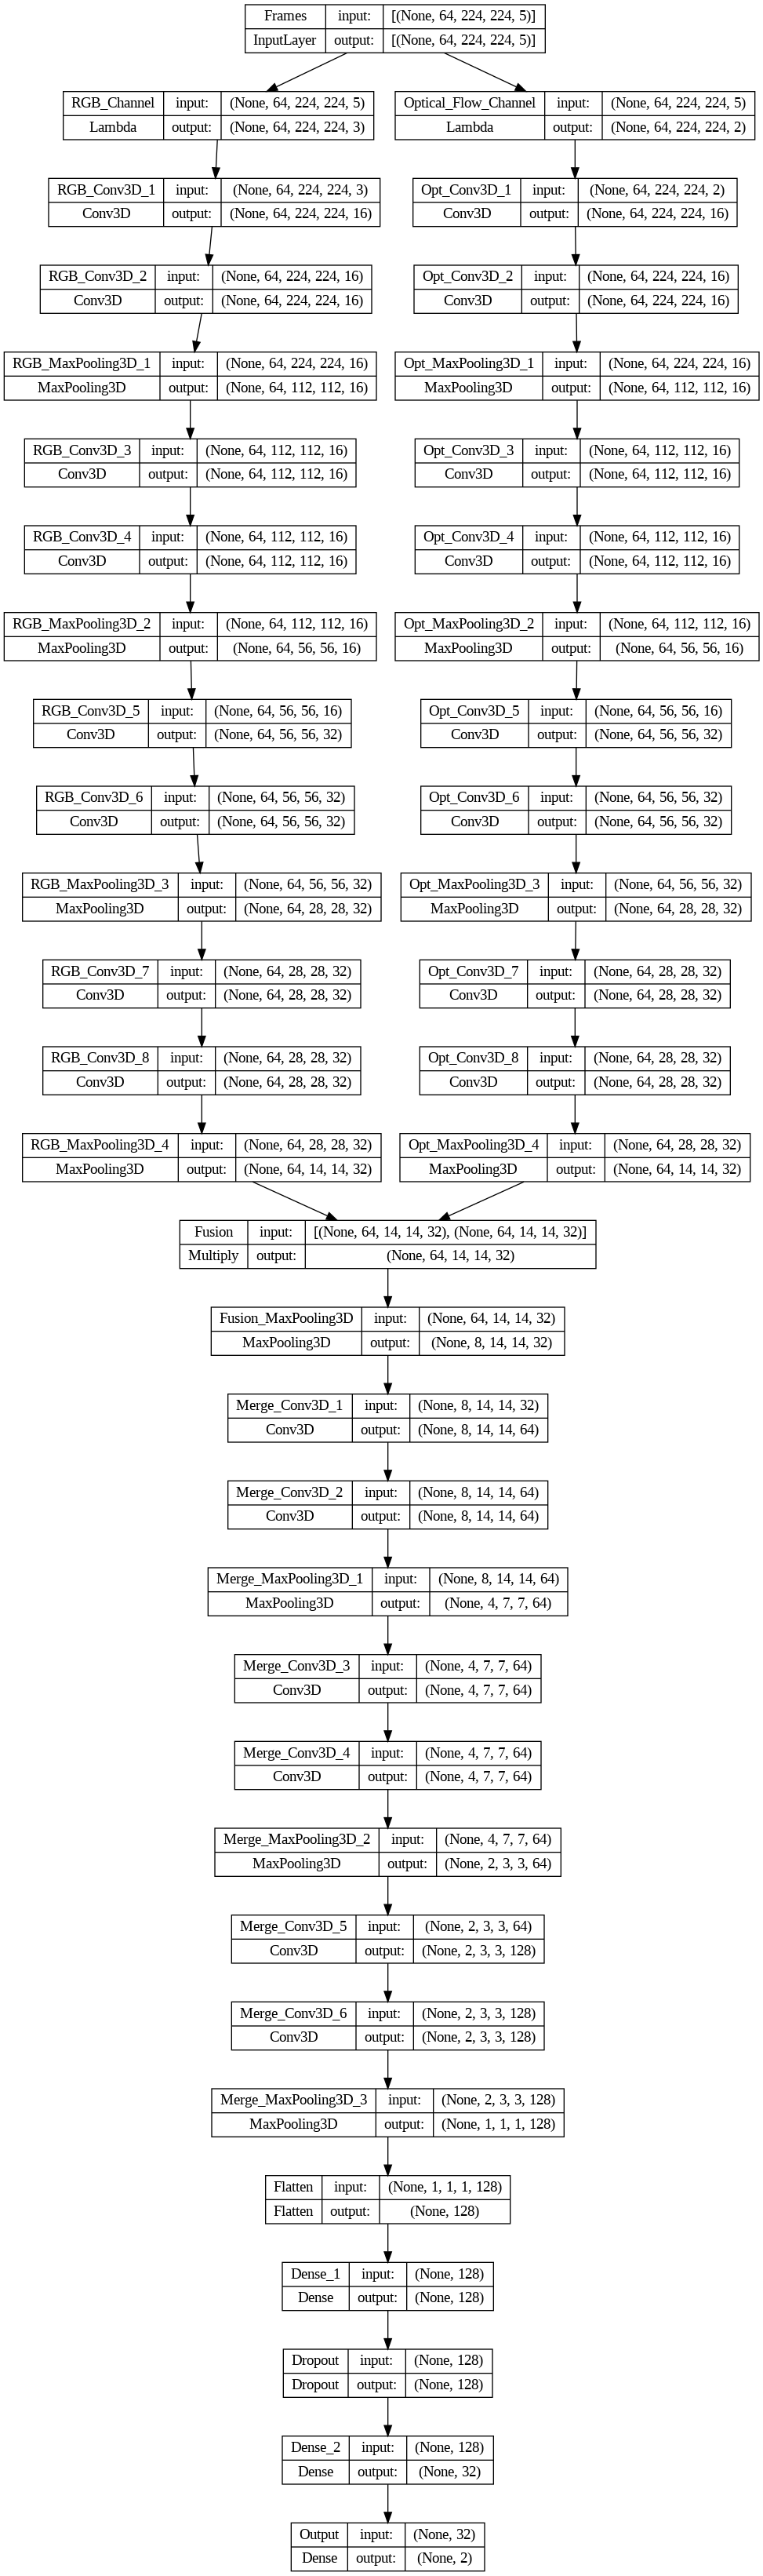

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Lambda, Conv3D, MaxPooling3D, Multiply, Flatten, Dense, Dropout
# from tensorflow.keras.utils import plot_model

# # Define the model
# inputs = Input(shape=(64, 224, 224, 5), name="Frames")

# # RGB and Optical Flow Channels
# def get_rgb(x):
#     return x[..., :3]

# def get_opt(x):
#     return x[..., 3:]

# rgb = Lambda(get_rgb, name="RGB_Channel")(inputs)
# opt = Lambda(get_opt, name="Optical_Flow_Channel")(inputs)

# # RGB Channel
# rgb = Conv3D(16, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_1")(rgb)
# rgb = Conv3D(16, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_2")(rgb)
# rgb = MaxPooling3D((1, 2, 2), name="RGB_MaxPooling3D_1")(rgb)
# rgb = Conv3D(16, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_3")(rgb)
# rgb = Conv3D(16, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_4")(rgb)
# rgb = MaxPooling3D((1, 2, 2), name="RGB_MaxPooling3D_2")(rgb)
# rgb = Conv3D(32, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_5")(rgb)
# rgb = Conv3D(32, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_6")(rgb)
# rgb = MaxPooling3D((1, 2, 2), name="RGB_MaxPooling3D_3")(rgb)
# rgb = Conv3D(32, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_7")(rgb)
# rgb = Conv3D(32, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="RGB_Conv3D_8")(rgb)
# rgb = MaxPooling3D((1, 2, 2), name="RGB_MaxPooling3D_4")(rgb)

# # Optical Flow Channel
# opt = Conv3D(16, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_1")(opt)
# opt = Conv3D(16, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_2")(opt)
# opt = MaxPooling3D((1, 2, 2), name="Opt_MaxPooling3D_1")(opt)
# opt = Conv3D(16, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_3")(opt)
# opt = Conv3D(16, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_4")(opt)
# opt = MaxPooling3D((1, 2, 2), name="Opt_MaxPooling3D_2")(opt)
# opt = Conv3D(32, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_5")(opt)
# opt = Conv3D(32, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_6")(opt)
# opt = MaxPooling3D((1, 2, 2), name="Opt_MaxPooling3D_3")(opt)
# opt = Conv3D(32, (1, 3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_7")(opt)
# opt = Conv3D(32, (3, 1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal', name="Opt_Conv3D_8")(opt)
# opt = MaxPooling3D((1, 2, 2), name="Opt_MaxPooling3D_4")(opt)

# # Fusion and Pooling
# x = Multiply(name="Fusion")([rgb, opt])
# x = MaxPooling3D((8, 1, 1), name="Fusion_MaxPooling3D")(x)

# # Merging Block
# x = Conv3D(64, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_1")(x)
# x = Conv3D(64, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_2")(x)
# x = MaxPooling3D((2, 2, 2), name="Merge_MaxPooling3D_1")(x)
# x = Conv3D(64, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_3")(x)
# x = Conv3D(64, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_4")(x)
# x = MaxPooling3D((2, 2, 2), name="Merge_MaxPooling3D_2")(x)
# x = Conv3D(128, (1, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_5")(x)
# x = Conv3D(128, (3, 1, 1), activation='relu', padding='same', kernel_initializer='he_normal', name="Merge_Conv3D_6")(x)
# x = MaxPooling3D((2, 3, 3), name="Merge_MaxPooling3D_3")(x)

# # Fully Connected Layers
# x = Flatten(name="Flatten")(x)
# x = Dense(128, activation='relu', name="Dense_1")(x)
# x = Dropout(0.2, name="Dropout")(x)
# x = Dense(32, activation='relu', name="Dense_2")(x)

# # Output Layer
# pred = Dense(2, activation='softmax', name="Output")(x)

# # Build the model
# model = Model(inputs=inputs, outputs=pred)

# # Plot the model
# plot_file = "model_plot.png"
# plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)
